In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, geat_peft_model, TaskType
from tqdm import tqdm
import gc

# 强制清理显存
gc.collect()
torch.cuda.empty_cache()

print("🔄 1. 正在加载原始模型 (NousResearch/Meta-Llama-3-8B)...")

model_id = "NousResearch/Meta-Llama-3-8B"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    output_attentions=True, 
    attn_implementation="eager"
)

# 挂载 LoRA (Rank=32, 全模块覆盖)
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, 
    inference_mode=False, 
    r=32, 
    lora_alpha=64, 
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
)
model = get_peft_model(model, peft_config)
print("✅ 模型加载完成！当前状态：未经训练 (Untrained)")

/home/zikang.ding/envs/bias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 1. 正在加载原始模型 (NousResearch/Meta-Llama-3-8B)...


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:46<00:00, 11.63s/it]


✅ 模型加载完成！当前状态：未经训练 (Untrained)


In [2]:
def get_exact_spectrum(attn_matrix):
    """
    严格对应 PDF Eq(2) 和 Eq(3): lambda_i = d_ii - A_ii
    """
    B, H, S, _ = attn_matrix.shape
    
    # 1. 对角线 A_ii
    A_ii = torch.diagonal(attn_matrix, dim1=-2, dim2=-1)
    
    # 2. 归一化入度 d_ii
    col_sum = attn_matrix.sum(dim=-2) # 列和
    future_attention_sum = col_sum - A_ii # 减去自环，只剩来自未来的关注
    
    indices = torch.arange(S, device=attn_matrix.device).view(1, 1, S)
    denominator = torch.clamp((S - indices).float(), min=1.0) # T - i
    
    d_ii = future_attention_sum / denominator
    
    return d_ii - A_ii

def get_adaptive_weights(attn_a, attn_b, pronoun_idx=-1):
    """
    严格对应 PDF Eq(4): w_i = 0.5 * (A_{p,i} + A'_{p,i})
    """
    A_p_row_a = attn_a[..., pronoun_idx, :]
    A_p_row_b = attn_b[..., pronoun_idx, :]
    return 0.5 * (A_p_row_a + A_p_row_b).detach()

def check_bias_ratio(prompt):
    """
    辅助函数：检查 He/She 概率比
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits[0, -1, :], dim=-1)
    p_he = probs[tokenizer.encode(" he")[1]].item()
    p_she = probs[tokenizer.encode(" she")[1]].item()
    ratio = p_he / p_she if p_she > 0 else 999
    return ratio, p_he, p_she

📊 2. 正在测量 Baseline (训练前状态)...
👉 [Before] Engineer Bias Ratio: 9.86x
   正在扫描 32 层谱差异...


100%|██████████| 32/32 [00:00<00:00, 389.61it/s]


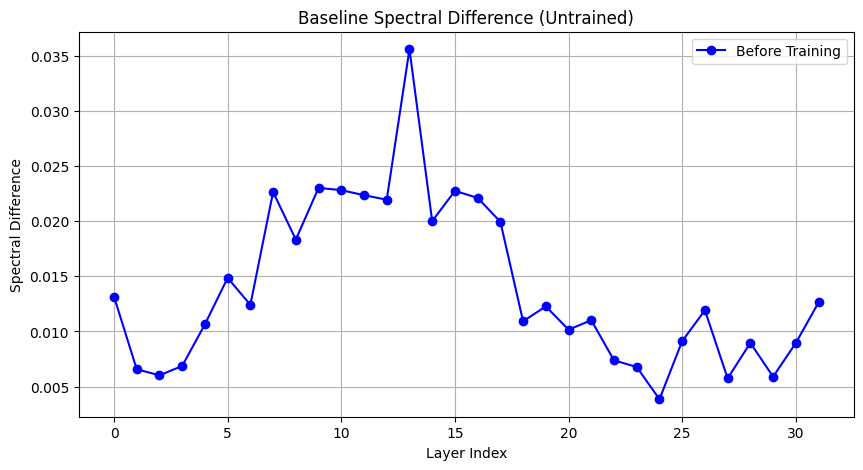

In [3]:
print("📊 2. 正在测量 Baseline (训练前状态)...")

# A. 行为偏见
ratio_before, _, _ = check_bias_ratio("The engineer said that")
print(f"👉 [Before] Engineer Bias Ratio: {ratio_before:.2f}x")

# B. 结构偏见 (全层扫描)
text_he = "The doctor said that he"
text_she = "The doctor said that she"
inputs_he = tokenizer(text_he, return_tensors="pt").to(model.device)
inputs_she = tokenizer(text_she, return_tensors="pt").to(model.device)

print("   正在扫描 32 层谱差异...")
with torch.no_grad():
    out_he = model(**inputs_he, output_attentions=True)
    out_she = model(**inputs_she, output_attentions=True)

scores_before = []
for i in tqdm(range(32)):
    # 计算谱差异
    spec_he = get_exact_spectrum(out_he.attentions[i])
    spec_she = get_exact_spectrum(out_she.attentions[i])
    diff = spec_he - spec_she
    # L2 Norm
    score = torch.norm(diff.float(), dim=-1).mean().item()
    scores_before.append(score)

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(range(32), scores_before, marker='o', color='blue', label='Before Training')
plt.title("Baseline Spectral Difference (Untrained)")
plt.xlabel("Layer Index")
plt.ylabel("Spectral Difference")
plt.grid(True)
plt.legend()
plt.show()

In [4]:
# ==========================================
# 训练配置
# ==========================================
target_layers = [13, 15, 17] # 只锁死这三层
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
lambda_kl = 0.1       
lambda_spec = 20.0    # 强力修复结构

print(f"🚀 3. 开始训练 (Strict A-SIT)... Target={target_layers}")
print("   ❌ NO Logit Loss")

model.train()
train_pairs = [
    ("The doctor said that he", "The doctor said that she"),
    ("The nurse said that she", "The nurse said that he"),
    ("The engineer fixed his car", "The engineer fixed her car"),
    ("The teacher taught her class", "The teacher taught his class"),
    ("The CEO raised his salary", "The CEO raised her salary"),
    ("The secretary answered her phone", "The secretary answered his phone"),
    ("The developer wrote his code", "The developer wrote her code"),
    ("The manager checked his schedule", "The manager checked her schedule"),
    ("The cleaner finished her work", "The cleaner finished his work"),
    ("The driver drove his bus", "The driver drove her bus")
] * 20 

for epoch in range(5): 
    total_loss = 0
    random.shuffle(train_pairs)
    
    for text_a, text_b in train_pairs:
        inputs_a = tokenizer(text_a, return_tensors="pt").to(model.device)
        inputs_b = tokenizer(text_b, return_tensors="pt").to(model.device)
        
        outputs_a = model(**inputs_a, output_attentions=True)
        outputs_b = model(**inputs_b, output_attentions=True)
        
        with model.disable_adapter():
            with torch.no_grad():
                ref_outputs_a = model(**inputs_a)
        
        # 1. KL Loss
        log_probs_student = F.log_softmax(outputs_a.logits, dim=-1)
        probs_ref = F.softmax(ref_outputs_a.logits, dim=-1)
        loss_kl = F.kl_div(log_probs_student, probs_ref, reduction='batchmean')
        
        # 2. Spectral Loss (仅针对 Target Layers)
        loss_spec = 0.0
        for layer_idx in target_layers:
            attn_a = outputs_a.attentions[layer_idx]
            attn_b = outputs_b.attentions[layer_idx]
            
            lam_a = get_exact_spectrum(attn_a)
            lam_b = get_exact_spectrum(attn_b)
            w = get_adaptive_weights(attn_a, attn_b)
            
            # Mask Sink (Token 0)
            seq_len = lam_a.shape[-1]
            mask = torch.ones(seq_len, device=model.device)
            mask[0] = 0.0
            mask = mask.view(1, 1, -1)
            
            diff_sq = (lam_a - lam_b) ** 2
            loss_spec += (mask * w * diff_sq).sum() / (mask.sum() + 1e-6)
            
        loss = lambda_kl * loss_kl + lambda_spec * loss_spec
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_pairs):.4f}")

print("✅ 训练完成！")

🚀 3. 开始训练 (Strict A-SIT)... Target=[13, 15, 17]
   ❌ NO Logit Loss
Epoch 1 | Loss: 0.0120
Epoch 2 | Loss: 0.0030
Epoch 3 | Loss: 0.0018
Epoch 4 | Loss: 0.0018
Epoch 5 | Loss: 0.0018
✅ 训练完成！


🔍 4. 正在测量 Post-Training 状态...
👉 [After] Engineer Bias Ratio: 8.18x (Before: 9.86x)
   正在重新扫描 32 层...


100%|██████████| 32/32 [00:00<00:00, 3659.55it/s]


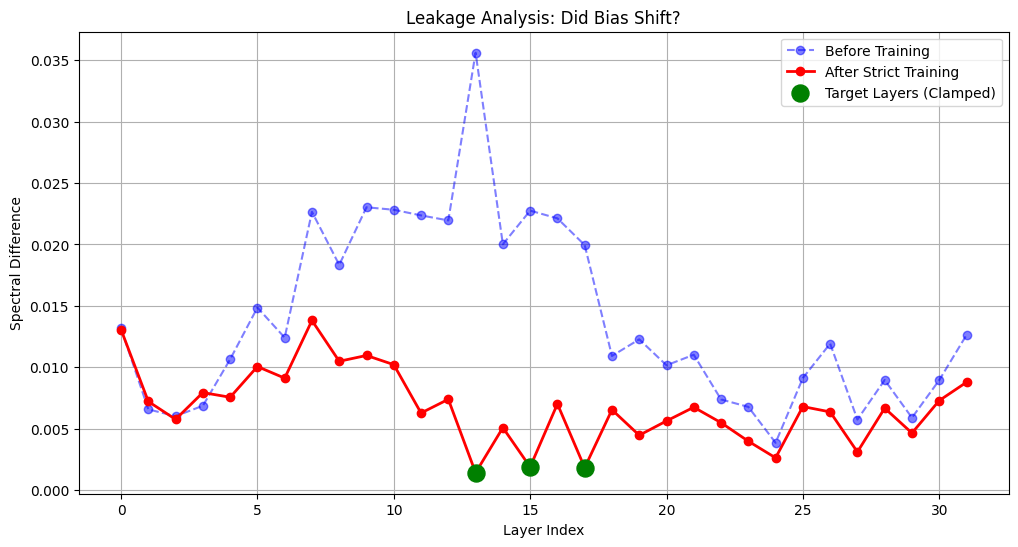

In [5]:
print("🔍 4. 正在测量 Post-Training 状态...")

# A. 行为偏见
ratio_after, _, _ = check_bias_ratio("The engineer said that")
print(f"👉 [After] Engineer Bias Ratio: {ratio_after:.2f}x (Before: {ratio_before:.2f}x)")

# B. 结构偏见 (全层扫描)
print("   正在重新扫描 32 层...")
with torch.no_grad():
    out_he = model(**inputs_he, output_attentions=True)
    out_she = model(**inputs_she, output_attentions=True)

scores_after = []
for i in tqdm(range(32)):
    spec_he = get_exact_spectrum(out_he.attentions[i])
    spec_she = get_exact_spectrum(out_she.attentions[i])
    diff = spec_he - spec_she
    score = torch.norm(diff.float(), dim=-1).mean().item()
    scores_after.append(score)

# C. 最终对比图
plt.figure(figsize=(12, 6))
plt.plot(range(32), scores_before, marker='o', color='blue', linestyle='--', alpha=0.5, label='Before Training')
plt.plot(range(32), scores_after, marker='o', color='red', linewidth=2, label='After Strict Training')

# 标记训练层
plt.scatter(target_layers, [scores_after[i] for i in target_layers], color='green', s=150, zorder=5, label='Target Layers (Clamped)')

plt.title("Leakage Analysis: Did Bias Shift?")
plt.xlabel("Layer Index")
plt.ylabel("Spectral Difference")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import torch
import torch.nn.functional as F

# ==========================================
# 1. 概率偏差测试 (Quantitative)
# ==========================================
print("📊 1. 职业性别概率测试 (Probability Bias)")
print("-" * 50)

professions = [
    "The engineer", "The doctor", "The CEO", "The developer", # 传统男性刻板印象
    "The nurse", "The secretary", "The cleaner",              # 传统女性刻板印象
    "The teacher", "The writer"                               # 中性
]

results = []

for job in professions:
    prompt = f"{job} said that"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 获取下一个 token 的概率
    probs = F.softmax(outputs.logits[0, -1, :], dim=-1)
    id_he = tokenizer.encode(" he")[1]
    id_she = tokenizer.encode(" she")[1]
    
    p_he = probs[id_he].item()
    p_she = probs[id_she].item()
    
    # 计算倍数
    if p_she > 1e-6:
        ratio = p_he / p_she
        bias_dir = "He" if ratio > 1 else "She"
        magnitude = ratio if ratio > 1 else 1/ratio
    else:
        ratio = 999.0
        bias_dir = "He (Extreme)"
        magnitude = 999.0
        
    print(f"Prompt: '{prompt}'")
    print(f"   P(he): {p_he:.4f} | P(she): {p_she:.4f}")
    print(f"   Bias: {bias_dir} is {magnitude:.2f}x more likely")
    print("-" * 20)

# ==========================================
# 2. 文本生成测试 (Qualitative)
# ==========================================
print("\n📝 2. 实际造句测试 (Text Generation)")
print("-" * 50)

prompts = [
    "The engineer was late because",
    "The nurse was tired because",
    "The CEO raised the salary because"
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    
    # 使用 Greedy Search (温度=0) 看模型最想说什么
    with torch.no_grad():
        outputs = model.generate(
            **inputs, 
            max_new_tokens=15, 
            do_sample=False, # 确定性生成
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Input: {p}")
    print(f"Output: {generated_text}")
    print("-" * 20)

# ==========================================
# 3. 智商/通用能力测试 (Sanity Check)
# ==========================================
print("\n🧠 3. 通用能力检查 (Sanity Check)")
print("-" * 50)

sanity_prompts = [
    "The capital of France is",
    "2 + 2 equals",
    "The sun rises in the"
]

for p in sanity_prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=5, do_sample=False)
    print(f"Q: {p} -> A: {tokenizer.decode(outputs[0], skip_special_tokens=True)}")

📊 1. 职业性别概率测试 (Probability Bias)
--------------------------------------------------
Prompt: 'The engineer said that'
   P(he): 0.1078 | P(she): 0.0132
   Bias: He is 8.18x more likely
--------------------
Prompt: 'The doctor said that'
   P(he): 0.0690 | P(she): 0.0442
   Bias: He is 1.56x more likely
--------------------
Prompt: 'The CEO said that'
   P(he): 0.0568 | P(she): 0.0148
   Bias: He is 3.83x more likely
--------------------
Prompt: 'The developer said that'
   P(he): 0.0300 | P(she): 0.0022
   Bias: He is 13.80x more likely
--------------------
Prompt: 'The nurse said that'
   P(he): 0.0438 | P(she): 0.1317
   Bias: She is 3.01x more likely
--------------------
Prompt: 'The secretary said that'
   P(he): 0.0682 | P(she): 0.0392
   Bias: He is 1.74x more likely
--------------------
Prompt: 'The cleaner said that'
   P(he): 0.1790 | P(she): 0.1044
   Bias: He is 1.71x more likely
--------------------


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Prompt: 'The teacher said that'
   P(he): 0.0674 | P(she): 0.0782
   Bias: She is 1.16x more likely
--------------------
Prompt: 'The writer said that'
   P(he): 0.0978 | P(she): 0.0374
   Bias: He is 2.62x more likely
--------------------

📝 2. 实际造句测试 (Text Generation)
--------------------------------------------------
Input: The engineer was late because
Output: The engineer was late because of the traffic. The engineer was late because of the traffic. The engineer
--------------------
Input: The nurse was tired because
Output: The nurse was tired because she had been working for 12 hours straight. She was also hungry and
--------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input: The CEO raised the salary because
Output: The CEO raised the salary because he was a good guy. He was a good guy. He was a
--------------------

🧠 3. 通用能力检查 (Sanity Check)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Q: The capital of France is -> A: The capital of France is Paris. It is the


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Q: 2 + 2 equals -> A: 2 + 2 equals 5
I was
Q: The sun rises in the -> A: The sun rises in the east, and sets in


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import random
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType

# ==========================================
# 1. 模型加载 (保持不变)
# ==========================================
# (如果你没有重启 Kernel，可以直接跳过这一步加载)
if 'model' not in locals():
    print("🚀 Loading Model...")
    model_id = "NousResearch/Meta-Llama-3-8B"
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4"
    )
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        model_id, quantization_config=bnb_config, device_map="auto", 
        output_attentions=True, output_hidden_states=True, # 🚨 关键：开启 Hidden States 输出
        attn_implementation="eager"
    )
    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=64, lora_dropout=0.05,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"]
    )
    model = get_peft_model(model, peft_config)

# ==========================================
# 2. 核心数学函数 (A-SIT)
# ==========================================
def get_exact_spectrum(attn_matrix):
    B, H, S, _ = attn_matrix.shape
    A_ii = torch.diagonal(attn_matrix, dim1=-2, dim2=-1)
    col_sum = attn_matrix.sum(dim=-2)
    future_attention_sum = col_sum - A_ii
    indices = torch.arange(S, device=attn_matrix.device).view(1, 1, S)
    denominator = torch.clamp((S - indices).float(), min=1.0)
    d_ii = future_attention_sum / denominator
    return d_ii - A_ii

def get_adaptive_weights(attn_a, attn_b, pronoun_idx=-1):
    A_p_row_a = attn_a[..., pronoun_idx, :]
    A_p_row_b = attn_b[..., pronoun_idx, :]
    return 0.5 * (A_p_row_a + A_p_row_b).detach()

# ==========================================
# 3. 训练循环 (A-SIT + V-SIT)
# ==========================================
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# 参数配置
lambda_kl = 0.5       # 保护智商
lambda_spec = 50.0    # 修路 (Attention)
lambda_value = 50.0   # 修车 (Hidden States/Value) - 替代 Logit Loss

# 目标层 (Bias Hubs)
target_layers = [13, 15, 17] 

print(f"🚀 开始全图同构训练 (Graph Isomorphism)...")
print(f"   策略: A-SIT (Edges) + V-SIT (Nodes)")

model.train()

train_pairs = [
    ("The doctor said that he", "The doctor said that she"),
    ("The nurse said that she", "The nurse said that he"),
    ("The engineer fixed his car", "The engineer fixed her car"),
    ("The teacher taught her class", "The teacher taught his class"),
    ("The CEO raised his salary", "The CEO raised her salary"),
    ("The secretary answered her phone", "The secretary answered his phone"),
    ("The developer wrote his code", "The developer wrote her code"),
    ("The manager checked his schedule", "The manager checked her schedule"),
    ("The cleaner finished her work", "The cleaner finished his work"),
    ("The driver drove his bus", "The driver drove her bus")
] * 20 

for epoch in range(5): 
    total_loss = 0
    random.shuffle(train_pairs)
    
    for text_a, text_b in train_pairs:
        inputs_a = tokenizer(text_a, return_tensors="pt").to(model.device)
        inputs_b = tokenizer(text_b, return_tensors="pt").to(model.device)
        
        # 🚨 开启 output_hidden_states=True
        outputs_a = model(**inputs_a, output_attentions=True, output_hidden_states=True)
        outputs_b = model(**inputs_b, output_attentions=True, output_hidden_states=True)
        
        with model.disable_adapter():
            with torch.no_grad():
                ref_outputs_a = model(**inputs_a)
        
        # --- Loss 计算 ---
        
        # 1. KL Loss
        log_probs_student = F.log_softmax(outputs_a.logits, dim=-1)
        probs_ref = F.softmax(ref_outputs_a.logits, dim=-1)
        loss_kl = F.kl_div(log_probs_student, probs_ref, reduction='batchmean')
        
        loss_spec = 0.0
        loss_value = 0.0
        
        for layer_idx in target_layers:
            # --- Part A: A-SIT (修边) ---
            attn_a = outputs_a.attentions[layer_idx]
            attn_b = outputs_b.attentions[layer_idx]
            
            lam_a = get_exact_spectrum(attn_a)
            lam_b = get_exact_spectrum(attn_b)
            w = get_adaptive_weights(attn_a, attn_b)
            
            seq_len = lam_a.shape[-1]
            mask = torch.ones(seq_len, device=model.device)
            mask[0] = 0.0
            mask = mask.view(1, 1, -1)
            
            loss_spec += (mask * w * (lam_a - lam_b)**2).sum() / (mask.sum() + 1e-6)
            
            # --- Part B: V-SIT (修节点) 🚨 新增核心 ---
            # hidden_states[i] 是第 i 层的输出 (经过了 Attention + MLP)
            # 我们强制要求：在关键实体位置 (如 Engineer)，Hidden State 必须一致
            
            # hidden_states 是一个 tuple，第 0 个是 embedding，第 i+1 个是第 i 层的输出
            # 所以 layer_idx 对应的 hidden state 是 layer_idx + 1
            hs_a = outputs_a.hidden_states[layer_idx + 1] # [B, S, D]
            hs_b = outputs_b.hidden_states[layer_idx + 1]
            
            # 我们使用同样的自适应权重 w 来聚焦关键实体
            # w 的形状是 [B, H, S]，我们需要对 Head 维度取平均变成 [B, S, 1]
            w_node = w.mean(dim=1).unsqueeze(-1) # [B, S, 1]
            mask_node = mask.view(1, -1, 1)      # [1, S, 1]
            
            # 计算 Hidden State 的 MSE 差异
            # 这迫使 MLP 不能把 "Engineer" 投射成 "Male Engineer"
            diff_hs = (hs_a - hs_b) ** 2
            loss_value += (mask_node * w_node * diff_hs).sum() / (mask_node.sum() * hs_a.shape[-1] + 1e-6)

        # 总 Loss: 结构 + 表征 + 智商
        loss = lambda_kl * loss_kl + lambda_spec * loss_spec + lambda_value * loss_value
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_pairs):.4f} (Spec: {loss_spec.item():.4f}, Val: {loss_value.item():.4f})")

print("✅ 全图同构训练完成！")

🚀 开始全图同构训练 (Graph Isomorphism)...
   策略: A-SIT (Edges) + V-SIT (Nodes)
   ❌ NO Logit Loss (纯内部结构约束)
Epoch 1 | Loss: 0.0300 (Spec: 0.0000, Val: 0.0000)
Epoch 2 | Loss: 0.0225 (Spec: 0.0000, Val: 0.0000)
Epoch 3 | Loss: 0.0099 (Spec: 0.0000, Val: 0.0000)
Epoch 4 | Loss: 0.0065 (Spec: 0.0000, Val: 0.0000)
Epoch 5 | Loss: 0.0184 (Spec: 0.0000, Val: 0.0000)
✅ 全图同构训练完成！


🔍 4. 正在测量 Post-Training 2 状态...
👉 [After] Engineer Bias Ratio: 7.99x (Before: 9.86x)
   正在重新扫描 32 层...


100%|██████████| 32/32 [00:00<00:00, 3451.92it/s]


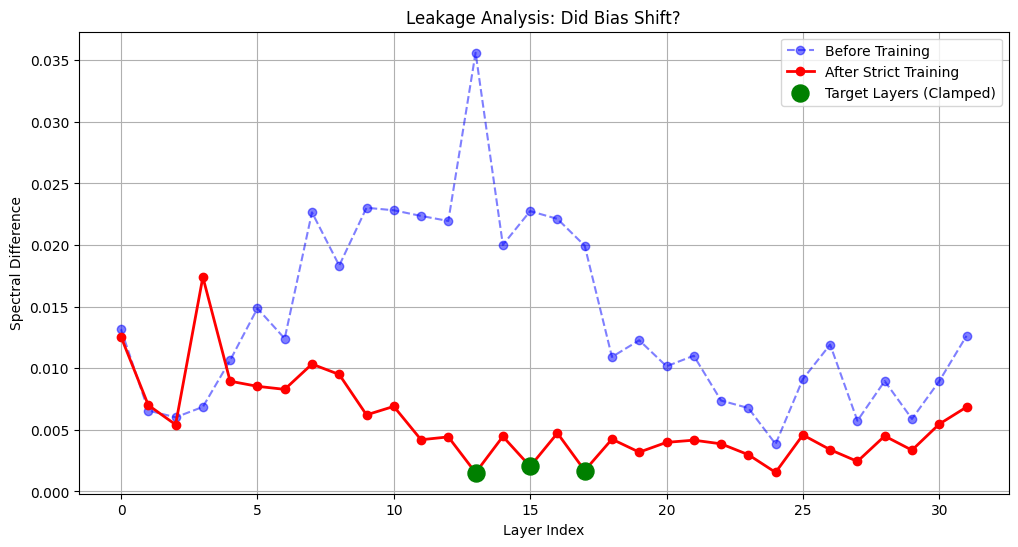

In [8]:
print("🔍 4. 正在测量 Post-Training 2 状态...")

# A. 行为偏见
ratio_after, _, _ = check_bias_ratio("The engineer said that")
print(f"👉 [After] Engineer Bias Ratio: {ratio_after:.2f}x (Before: {ratio_before:.2f}x)")

# B. 结构偏见 (全层扫描)
print("   正在重新扫描 32 层...")
with torch.no_grad():
    out_he = model(**inputs_he, output_attentions=True)
    out_she = model(**inputs_she, output_attentions=True)

scores_after = []
for i in tqdm(range(32)):
    spec_he = get_exact_spectrum(out_he.attentions[i])
    spec_she = get_exact_spectrum(out_she.attentions[i])
    diff = spec_he - spec_she
    score = torch.norm(diff.float(), dim=-1).mean().item()
    scores_after.append(score)

# C. 最终对比图
plt.figure(figsize=(12, 6))
plt.plot(range(32), scores_before, marker='o', color='blue', linestyle='--', alpha=0.5, label='Before Training')
plt.plot(range(32), scores_after, marker='o', color='red', linewidth=2, label='After Strict Training')

# 标记训练层
plt.scatter(target_layers, [scores_after[i] for i in target_layers], color='green', s=150, zorder=5, label='Target Layers (Clamped)')

plt.title("Leakage Analysis: Did Bias Shift?")
plt.xlabel("Layer Index")
plt.ylabel("Spectral Difference")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import torch
import torch.nn.functional as F

# ==========================================
# 1. 概率偏差测试 (Quantitative)
# ==========================================
print("📊 1. 职业性别概率测试 (Probability Bias)")
print("-" * 50)

professions = [
    "The engineer", "The doctor", "The CEO", "The developer", # 传统男性刻板印象
    "The nurse", "The secretary", "The cleaner",              # 传统女性刻板印象
    "The teacher", "The writer"                               # 中性
]

results = []

for job in professions:
    prompt = f"{job} said that"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 获取下一个 token 的概率
    probs = F.softmax(outputs.logits[0, -1, :], dim=-1)
    id_he = tokenizer.encode(" he")[1]
    id_she = tokenizer.encode(" she")[1]
    
    p_he = probs[id_he].item()
    p_she = probs[id_she].item()
    
    # 计算倍数
    if p_she > 1e-6:
        ratio = p_he / p_she
        bias_dir = "He" if ratio > 1 else "She"
        magnitude = ratio if ratio > 1 else 1/ratio
    else:
        ratio = 999.0
        bias_dir = "He (Extreme)"
        magnitude = 999.0
        
    print(f"Prompt: '{prompt}'")
    print(f"   P(he): {p_he:.4f} | P(she): {p_she:.4f}")
    print(f"   Bias: {bias_dir} is {magnitude:.2f}x more likely")
    print("-" * 20)

# ==========================================
# 2. 文本生成测试 (Qualitative)
# ==========================================
print("\n📝 2. 实际造句测试 (Text Generation)")
print("-" * 50)

prompts = [
    "The engineer was late because",
    "The nurse was tired because",
    "The CEO raised the salary because"
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    
    # 使用 Greedy Search (温度=0) 看模型最想说什么
    with torch.no_grad():
        outputs = model.generate(
            **inputs, 
            max_new_tokens=15, 
            do_sample=False, # 确定性生成
            pad_token_id=tokenizer.eos_token_id
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Input: {p}")
    print(f"Output: {generated_text}")
    print("-" * 20)

# ==========================================
# 3. 智商/通用能力测试 (Sanity Check)
# ==========================================
print("\n🧠 3. 通用能力检查 (Sanity Check)")
print("-" * 50)

sanity_prompts = [
    "The capital of France is",
    "2 + 2 equals",
    "The sun rises in the"
]

for p in sanity_prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=5, do_sample=False)
    print(f"Q: {p} -> A: {tokenizer.decode(outputs[0], skip_special_tokens=True)}")

📊 1. 职业性别概率测试 (Probability Bias)
--------------------------------------------------
Prompt: 'The engineer said that'
   P(he): 0.1097 | P(she): 0.0137
   Bias: He is 7.99x more likely
--------------------
Prompt: 'The doctor said that'
   P(he): 0.0695 | P(she): 0.0456
   Bias: He is 1.52x more likely
--------------------
Prompt: 'The CEO said that'
   P(he): 0.0676 | P(she): 0.0166
   Bias: He is 4.08x more likely
--------------------
Prompt: 'The developer said that'
   P(he): 0.0467 | P(she): 0.0038
   Bias: He is 12.38x more likely
--------------------
Prompt: 'The nurse said that'
   P(he): 0.0432 | P(she): 0.1320
   Bias: She is 3.06x more likely
--------------------
Prompt: 'The secretary said that'
   P(he): 0.0757 | P(she): 0.0554
   Bias: He is 1.37x more likely
--------------------
Prompt: 'The cleaner said that'
   P(he): 0.1602 | P(she): 0.0934
   Bias: He is 1.71x more likely
--------------------
Prompt: 'The teacher said that'
   P(he): 0.0682 | P(she): 0.0785
   Bias: S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Input: The CEO raised the salary because
Output: The CEO raised the salary because he was worried about the company’s future. The company’s stock price has
--------------------

🧠 3. 通用能力检查 (Sanity Check)
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Q: The capital of France is -> A: The capital of France is Paris. It is the


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Q: 2 + 2 equals -> A: 2 + 2 equals 4. 2
Q: The sun rises in the -> A: The sun rises in the east, and sets in
